# Wilks' theorem and variance estimates

In this notebook we use a toy example to illustrate the degree to which Wilks' theorem breaks down when we use different estimates for the true variance.

---

### Summary

We expect the test statistic 
\begin{equation}
\Delta\chi^2 = \frac{|\vec p\left(\vec c\right) - \vec x|^2}{\vec{\Delta^2}}
\end{equation}
to be distributed like a $\Delta\chi^2$ distribution with d.o.f. equal to the number of parameters of interest if (i) all sources of variance are Gaussian and **(ii) $\Delta^2$ is the expected variance around the true value of $c$**. This is a problem, since we do no have access to the _true_ value of a parameter we are trying to estimate. Instead, we use an estimator for the true variance. Following the approach of Emily's studies, we consider three strategies:

**Strategy 1**:  $\vec{\Delta^2}~=~\vec x$ is estimated from the data

**Strategy 2**:  $\vec{\Delta^2}~=~p\left(\vec c\right)$ is estimated from the value of $c$ being evaluated

**Strategy 2**:  $\vec{\Delta^2}~=~p\left(\vec c_{\rm true}\right)$ is estimated from the true value of $c$ (even though this is impossible in real life, it provides a control to show how well Wilks' holds for our toy example)

In this notebook we create a toy scenario, throw toys, and work out the expected distribution of the $\Delta\chi^2$ test statistic using these three different strategies.

---

In [1]:
#
#  Required imports
#

import math, sys
import numpy      as     np
from   scipy      import stats
from   matplotlib import pyplot as plt
from   iminuit    import Minuit


In [2]:
#
#  Config values
#

SM_values      = np.array([15, 30])     # Differential event yields for SM (>20 to be Gaussian-like)
EFT_lin_values = np.array([2 , 7 ])     # Additional event yields per unit Wilson coefficient

c_true    = 0.                # True Wilson coefficient value
num_toys  = int(1e6)          # Number of toys to throw
toys_type = "poisson"         # Distribution to throw toys from, choose from [poisson, gaussian]

migrad_precision = 1e-3      # Precision of migrad (lower number -> more precise min-chi2 estimate)


In [3]:
#
#  Define stats functions
#

def get_pred (c) :
    type_c = type(c)
    if type_c in [list, np.ndarray] :
        return type_c([get_pred(cp) for cp in c])
    return SM_values + c*EFT_lin_values

def get_q (c, x, strategy=1) :
    assert strategy in [1, 2, 3]
    type_c = type(c)
    if type_c in [list, np.ndarray] : return type_c([get_q(cp, x, strategy=strategy) for cp in c])
    pred  = get_pred(c)
    res   = pred - x
    ex_sq = x
    if strategy == 2 : ex_sq = pred
    if strategy == 3 : ex_sq = get_pred(c_true)
    return np.sum(res*res/ex_sq)

def get_q_best (x, strategy=1) :
    chi2 = lambda params : get_q (params[0], x, strategy=strategy)
    m = Minuit.from_array_func(chi2, [0], [0.5], errordef=1)
    m.migrad(precision=migrad_precision)
    return m.np_values()[0], m.get_fmin().fval, m
    
def get_q1      (c, x) : return get_q      (c, x, strategy=1)
def get_q1_best (x)    : return get_q_best (x   , strategy=1)
    
def get_q2      (c, x) : return get_q      (c, x, strategy=2)
def get_q2_best (x)    : return get_q_best (x   , strategy=2)
    
def get_q3      (c, x) : return get_q      (c, x, strategy=3)
def get_q3_best (x)    : return get_q_best (x   , strategy=3)

def get_dchi2_q1 (c, x) :
    _, q1_best, m1 = get_q1_best(x)
    return get_q1(c, x) - q1_best, m1.get_fmin().is_valid

def get_dchi2_q2 (c, x) :
    _, q2_best, m2 = get_q2_best(x)
    return get_q2(c, x) - q2_best, m2.get_fmin().is_valid

def get_dchi2_q3 (c, x) :
    _, q3_best, m3 = get_q3_best(x)
    return get_q3(c, x) - q3_best, m3.get_fmin().is_valid

def throw_gaussian_toys (c, num_toys=1) :
    pred = get_pred(c)
    std  = np.sqrt(pred)
    return pred + np.random.normal(size=(num_toys,len(pred)))*std

def throw_poisson_toys (c, num_toys=1) :
    pred = get_pred(c)
    return np.array([np.random.poisson(p, size=(num_toys,)) for p in pred]).transpose()
    

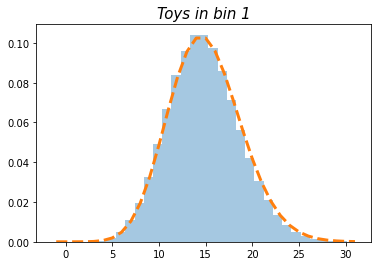

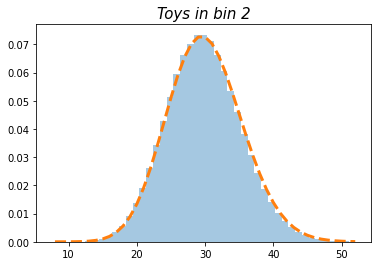

Running toy 1000000 / 1000000
999693 valid toys completed for strategy (1)
906635 valid toys completed for strategy (2)
999500 valid toys completed for strategy (3)


In [4]:
#
#  Throw toys and work out the expected dchi2 distributions using the three different strategies
#

assert toys_type in ["poisson", "gaussian"]

if toys_type == "poisson"  :
    toys = throw_poisson_toys (c_true, num_toys)
    for bin_idx in range(len(SM_values)) :
        bin_lo = math.floor(SM_values[bin_idx] - 4*np.sqrt(SM_values[bin_idx]))
        bin_hi = math.ceil (SM_values[bin_idx] + 4*np.sqrt(SM_values[bin_idx]))
        bins = np.linspace(bin_lo-0.5, bin_hi+0.1, bin_hi-bin_lo+2)
        x    = np.linspace(bin_lo, bin_hi, bin_hi-bin_lo+1)
        plt.hist(toys[:,bin_idx], density=True, bins=bins, alpha=0.4)
        plt.plot(x, stats.poisson.pmf(x, mu=SM_values[bin_idx]), "--", lw=3)
        plt.gca().set_title(f"Toys in bin {1+bin_idx}", style="italic", fontsize=15)
        plt.show()
        
if toys_type == "gaussian" :
    toys = throw_gaussian_toys(c_true, num_toys)
    for bin_idx in range(len(SM_values)) :
        bin_lo = SM_values[bin_idx] - 4*np.sqrt(SM_values[bin_idx])
        bin_hi = SM_values[bin_idx] + 4*np.sqrt(SM_values[bin_idx])
        x = np.linspace(bin_lo, bin_hi, 401)
        plt.hist(toys[:,bin_idx], density=True, bins=np.linspace(bin_lo, bin_hi, 81), alpha=0.4)
        plt.plot(x, stats.norm.pdf(x, loc=SM_values[bin_idx], scale=np.sqrt(SM_values[bin_idx])), "--", lw=3)
        plt.gca().set_title(f"Toys in bin {1+bin_idx}", style="italic", fontsize=15)
        plt.show()

dchi_strat1, dchi_strat2, dchi_strat3 = [], [], []

for toy_idx, toy in enumerate(toys) :
    sys.stdout.write(f"\rRunning toy {toy_idx+1} / {num_toys}")
    dchi2_q1, is_valid_1 = get_dchi2_q1(c_true, toy)
    dchi2_q2, is_valid_2 = get_dchi2_q2(c_true, toy)
    dchi2_q3, is_valid_3 = get_dchi2_q3(c_true, toy)
    if is_valid_1 : dchi_strat1.append(dchi2_q1)
    if is_valid_2 : dchi_strat2.append(dchi2_q2)
    if is_valid_3 : dchi_strat3.append(dchi2_q3)

print()
print(f"{len(dchi_strat1)} valid toys completed for strategy (1)")
print(f"{len(dchi_strat2)} valid toys completed for strategy (2)")
print(f"{len(dchi_strat3)} valid toys completed for strategy (3)")


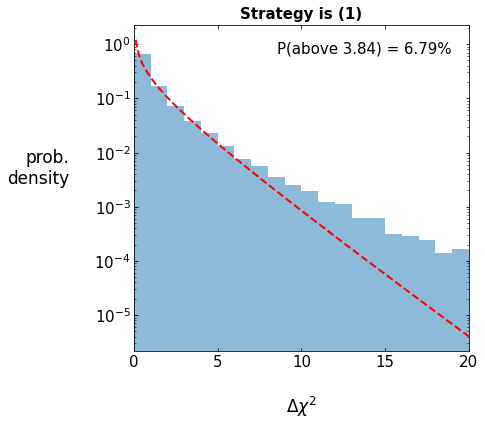

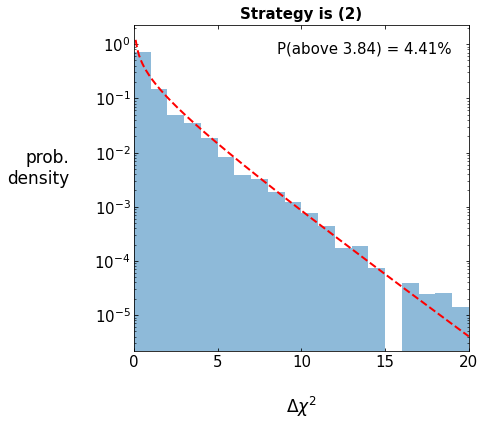

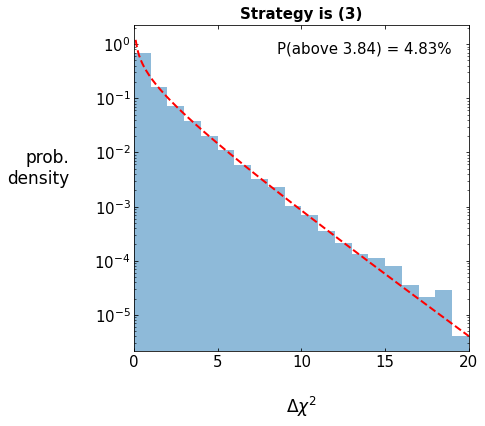

In [6]:
#  Plot the expected dchi2 distributions using the three strategies

def make_plot (dchi2_vals, strategy, upper_lim=20) :
    fig = plt.figure(figsize=(6, 6))
    ax  = fig.add_subplot(1, 1, 1)

    bins = np.linspace(0, upper_lim, int(upper_lim)+1)
    x    = np.linspace(0, upper_lim, int(10*upper_lim)+1)
    ax.hist(dchi2_vals, density=True, alpha=0.5, bins=bins, label="toys")
    ax.plot(x, stats.chi2.pdf(x, df=1), "--", lw=2, c="r", label=r"$\Delta\chi^2$(dof=1)")
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_yscale("log")
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=15)
    ax.set_xlabel(r"$\Delta\chi^2$", fontsize=17, labelpad=25, weight="bold")
    ax.set_ylabel("prob.\ndensity" , fontsize=17, labelpad=25, rotation=0, ha="right")
    ax.set_title(f"Strategy is {strategy}", fontsize=15, weight="bold")
    
    xx = np.linspace(3, 4.5, 1001)
    yy = stats.chi2.cdf(xx, df=1)
    lvl_95pct = np.interp(0.95, yy, xx)
    num_above_95pct = len([True for v in dchi2_vals if v > lvl_95pct])
    ax.text(0.95, 0.95, f"P(above {lvl_95pct:.2f}) = {100.*num_above_95pct/len(dchi2_vals):.2f}%", ha="right", va="top", fontsize=15, transform=ax.transAxes)

    plt.show()
    
make_plot(dchi_strat1, "(1)")
make_plot(dchi_strat2, "(2)")
make_plot(dchi_strat3, "(3)")
